<a href="https://colab.research.google.com/github/nioclandramer/IA_ComSexista/blob/main/IA_comentSexistas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CLASIFICACIÓN DEL SEXISMO EN TEXTOS EN INGLÉS**


---




Inteligencia Artificial G3 2024-2

Grupo de trabajo No. 3
* Kevin Arias
* Gabriela Cera
* Andrés Echeverri
* Leonard Ferreira





# 🟣 **Descripción del problema**

El siguiente trabajo se realiza a base del conjunto de datos tomado de: https://www.kaggle.com/datasets/aadyasingh55/sexism-detection-in-english-texts?resource=download

Este conjunto de datos incluye 14000 entradas de texto en inglés para el archivo train y 4000 para el archivo test y 4 columnas:
* ***Text:*** Contiene al comentario.
* ***Label_sexist:*** Clasifica al comentario en sexista y no sexista.
* ***Label_category:*** Clasifica los comentarios, "***none***" si no es sexista, y si lo es, hay 4 tipos:
 1. ***Threats, plans to harm and incitement* (Amenazas)**: Expresar la intención de causar daño físico o psicológico a alguien por su género. Ej: "Te voy a pegar".
 2. ***Derogation* (Derogación)**: Despreciar o humillar a una persona por su género. Ej: "Las mujeres no saben conducir".
 3. ***Animosity* (Animosidad)**: Sentir odio o resentimiento hacia las mujeres. Ej: "Odio a las feministas".
 4. ***Prejudiced discussions* (Discusiones prejuiciosas)**: Difundir creencias falsas sobre las mujeres y justificar la desigualdad de género. Ej: "Los hombres son los jefes de la casa".

* ***Label_vector:*** Es una subcategoría, contiene: "***none***" y:
 2. 1 descriptive attacks
 2. 2 aggressive and emotive attacks
 3. 1 casual use of gendered slurs, profanities, and insults
 3. 2 immutable gender differences and gender stereotypes


**Objetivos específicos:**

Este trabajo solo se enfoca en los comentarios sexistas y en sus 4 categorías, con estos datos los objetivos son:

* **Realizar Análisis Exploratorio de Datos (EDA):** Analizar la distribución y características de los comentarios sexistas.

* **Filtrar y Preprocesar Datos Sexistas:** Extraer y normalizar los comentarios sexistas y sus categorías en un formato comprensible para la máquina.

* **Dividir el Dataset:** Separar los datos sexistas en conjuntos de entrenamiento y prueba.

* **Seleccionar y Entrenar Modelos:** Investigar y entrenar el modelos de machine learning para la clasificación de comentarios sexistas.

* **Evaluar el Modelo:** Medir el rendimiento del modelo e identificar los errores.


**Descripción de variables:**

El nuevo dataset tendrá unicamente las variables:
* ***Text* (variable predictora X):** los comentarios sexistas
* ***Label_category* (variable objetivo Y):** con sus 4 categorías

**División del Dataset:** El dataset ya viene separado en Kaggle, en un archivo ***train*** (que llamaremos "datos") para entrenamiento y ***test*** para prueba; estos serán los que se usarán en el proyecto.

**Librerias utilizadas:**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

#Para graficos
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

#Para Preprocesamiento de datos
import re
  #Para corrección ortográfica
!pip install pyspellchecker
from spellchecker import SpellChecker

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#Para vectorizacion de datos
from sklearn.feature_extraction.text import TfidfVectorizer

#Para seleccion de características
from sklearn.feature_selection import chi2

#Para Modelo de Regresión logistica multinomial
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import numpy as np

#para balanceo de datos
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

#Para Modelo de Random Forest
from sklearn.ensemble import RandomForestClassifier

# 🟢 **Obtener y entender los datos**

**Carga y extracción del dataset:**

In [ ]:
# Ruta del archivo CSV en Google Drive
#dataset = "/content/drive/MyDrive/Colab Notebooks/dev.csv"
dataset = "/content/drive/MyDrive/Colab Notebooks/train (2).csv"

# Leer el archivo CSV en un DataFrame
datosOriginales = pd.read_csv(dataset, encoding='utf-8', nrows=100000)

# Verificar que los datos se hayan cargado correctamente
print("\n Dataset train:")
print(datosOriginales.head())
print("\n")
datosOriginales.info()
#___________________________________________________________________
dataset2 = "/content/drive/MyDrive/Colab Notebooks/test (1).csv"
datosTOriginales = pd.read_csv(dataset2, encoding='utf-8', nrows=100000)
print("\n Dataset test:")
print(datosTOriginales.head())
print("\n")
datosTOriginales.info()


 Dataset train:
                  rewire_id  \
0  sexism2022_english-16993   
1  sexism2022_english-13149   
2  sexism2022_english-13021   
3  sexism2022_english-14998   
4   sexism2022_english-7228   

                                                text label_sexist  \
0                            Then, she's a keeper. 😉   not sexist   
1  This is like the Metallica video where the poo...   not sexist   
2                                             woman?   not sexist   
3  Unlicensed day care worker reportedly tells co...   not sexist   
4  [USER] Leg day is easy. Hot girls who wear min...       sexist   

  label_category                         label_vector  split  
0           none                                 none  train  
1           none                                 none  train  
2           none                                 none  train  
3           none                                 none  train  
4   3. animosity  3.3 backhanded gendered compliments  train  


<

In [ ]:
#Extración de los comentarios sexistas más sus categorías (dos columnas):

# Filtrar las filas según el label (categoria)
filtrado = datosOriginales[datosOriginales['label_sexist'] == 'sexist']

# Seleccionar columnas específicas que conformarán los nuevos datos y hacer una copia
datos = filtrado[['text', 'label_category']].copy()

# Contar la cantidad de comentarios por tipo
conteo_tipos = datos['label_category'].value_counts()

# Mostrando el cambio
print("\n Dataset train:")
print(datos.head(10))
print("\n")
datos.info()

#_____________________________________________________________________________
filtradoT = datosTOriginales[datosTOriginales['label_sexist'] == 'sexist']
test = filtradoT[['text', 'label_category']].copy()
conteoT_tipos = test['label_category'].value_counts()
print("\n Dataset test:")
print(test.head(10))
print("\n")
test.info()


 Dataset train:
                                                 text  \
4   [USER] Leg day is easy. Hot girls who wear min...   
6   I get a new pussy every other week or whenever...   
11  O come on there's no way any men are attracted...   
21  Former BBC journalist Thuto Mali says that uni...   
25  I did. You have to have the bravery to escalat...   
31  Not going to lie, the brutal honesty of this r...   
33  Please.... take my wife, rape my daughter!! Bu...   
34  Pink is very feminine so I accept this bikini ...   
38  Yes. Especially these days, it takes a lot to ...   
39  Put a fork in Muslim-England she's done for an...   

                              label_category  
4                               3. animosity  
6                              2. derogation  
11                             2. derogation  
21                 4. prejudiced discussions  
25  1. threats, plans to harm and incitement  
31                 4. prejudiced discussions  
33  1. threats, plans to h

Observamos que el nuevo dataset **datos** (de entrenamiento) quedó con 3398 entradas de 14000, y **test** (de prueba) quedó con 970 de 4000

**Análisis Exploratorio de Datos (EDA):**

<ipython-input-95-592d5ea8e497>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_tipos.index, y=conteo_tipos.values, palette=colors)


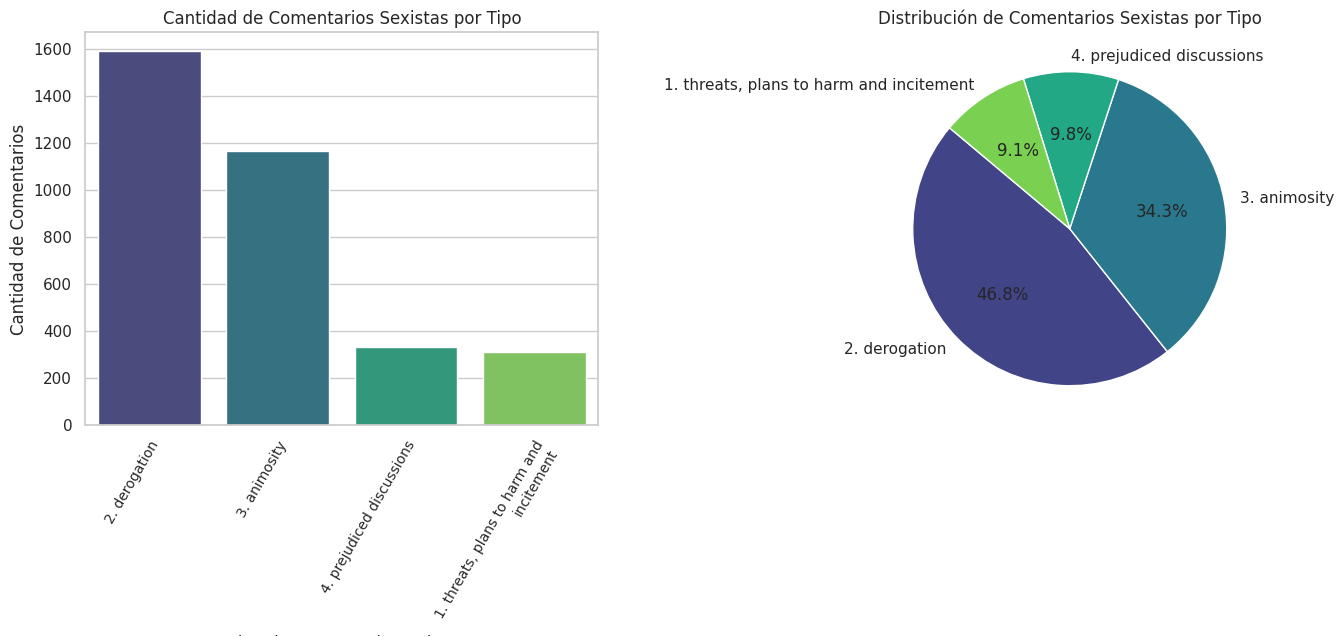

In [ ]:
# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Ajustar el tamaño de la figura según el número de categorías
fig_width = max(14, len(conteo_tipos) * 1.5)
plt.figure(figsize=(fig_width, 6))

# configuración para el gráfico de barras
plt.subplot(1, 2, 1)
colors = sns.color_palette("viridis", len(conteo_tipos))
sns.barplot(x=conteo_tipos.index, y=conteo_tipos.values, palette=colors)
plt.xlabel('Tipo de Comentario Sexista')
plt.ylabel('Cantidad de Comentarios')
plt.title('Cantidad de Comentarios Sexistas por Tipo')

# Rotar y ajustar el tamaño de las etiquetas en el eje x
plt.xticks(rotation=60, ha='right', fontsize=10, wrap=True)

# configuración para el gráfico de pastel
plt.subplot(1, 2, 2)
plt.pie(conteo_tipos.values, labels=conteo_tipos.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribución de Comentarios Sexistas por Tipo')

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()
plt.show()

🤔 Se observa que los datos están desbalanceados, más adelante se sabrá si esto afecta realmente a los resultados y si se deben tomar medidas al repecto

# 🔵 **Limpieza de los datos y feature engineering**


## 🔹 **Preprocesamiento de datos**

Para poder usar nuestro dataset como datos de entrenamiento, primero se debe procesar el texto que contiene siguiendo los siguientes pasos:

* **Limpieza de Datos:** verificar si hay duplicados o vacíos, y corregirlos si e presentan.
* **Normalización:** Convertir todo el texto a minúsculas, corregir algunos errores ortográficos, corregir contracciones mediante un diccionario, eliminar puntuación, caracteres especiales y números, reemplazar mutiples espacios en blanco por uno solo.
* **Tokenización:** Dividir el texto en palabras o tokens individuales.
* **Eliminación de Stop Words:** Quitar palabra que no aportan mucho significado (como "y", "el", "de").
* **Lematización:** Reducir las palabras a su raíz.



### Limpieza de datos:

**Revisión de valores nulos:**

In [ ]:
# Contar valores nulos en cada columna
print("\n Dataset train:")
nulos = datos.isnull().sum()
print(nulos)

# Obtener un resumen del dataframe
datos.info()
#____________________________________________
print("\n Dataset test:")
nulosT = test.isnull().sum()
print(nulosT)
test.info()


 Dataset train:
text              0
label_category    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 3398 entries, 4 to 13993
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            3398 non-null   object
 1   label_category  3398 non-null   object
dtypes: object(2)
memory usage: 79.6+ KB

 Dataset test:
text              0
label_category    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 970 entries, 1 to 3999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            970 non-null    object
 1   label_category  970 non-null    object
dtypes: object(2)
memory usage: 22.7+ KB


No se encuentran valores nulos en los datos de train y de test

**Revisión de filas duplicadas:**

In [ ]:
print("\n Dataset train:")
num_duplicados = datos.duplicated().sum()
print(f"Número de filas duplicadas: {num_duplicados}")

# Mostrar las filas duplicadas
if num_duplicados > 0:
    duplicados = datos[datos.duplicated(keep=False)]  # keep=False muestra todos los duplicados
    print("Filas duplicadas:")
    print(duplicados)

#_______________________________________________________________________________
print("\n Dataset test:")
num_duplicadosT = test.duplicated().sum()
print(f"Número de filas duplicadas: {num_duplicadosT}")
if num_duplicadosT > 0:
    duplicadosT = test[test.duplicated(keep=False)]  # keep=False muestra todos los duplicados
    print("Filas duplicadas:")
    print(duplicadosT)


 Dataset train:
Número de filas duplicadas: 0

 Dataset test:
Número de filas duplicadas: 0


### Normalización:

In [ ]:
contractions_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot", "cant": "cannot", #por si esta mal escrita
    "couldn't": "could not",
    "could've": "could have",
    "didn't": "did not",
    "doesn't": "does not", "dosn't": "does not",
    "don't": "do not",
    "dont": "do not",
    "gimme": "give me",
    "gonna": "going to",
    "gotta": "got to",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "im": "i am",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "mightn't": "might not",
    "might've": "might have",
    "mustn't": "must not",
    "must've": "must have",
    "needn't": "need not",
    "o'clock": "of the clock",
    "shan't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "shouldn't": "should not",
    "should've": "should have",
    "that's": "that is",
    "there'd": "there would",
    "there'll": "there will",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wanna": "want to",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'd": "what did",
    "what'll": "what will",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'd": "who would",
    "who'll": "who will",
    "who's": "who is",
    "who've": "who have",
    "why'd": "why did",
    "why'll": "why will",
    "why's": "why is",
    "won't": "will not",
    "wouldn't": "would not", "woudn't": "would not",
    "would've": "would have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all've": "you all have",
    "y'know": "you know",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have"
}

In [ ]:
# Inicializar el corrector ortográfico
spell = SpellChecker()

def normalizar_texto(texto):
    # Convertir a minúsculas
    texto = texto.lower()
    # Reemplazar el apóstrofo tipográfico por el apóstrofo simple
    #para que las contracciones se reemplacen bien
    texto = texto.replace("’", "'")

    # Corregir errores ortográficos
    palabras = texto.split()
    palabras_corregidas = [spell.candidates(p).pop() if p in spell else p for p in palabras]
    texto = ' '.join(palabras_corregidas)

    #Eliminar contracciones
    for contraccion, expansion in contractions_dict.items():
        texto = re.sub(r'\b' + re.escape(contraccion) + r'\b', expansion, texto)
    # Eliminar puntuación, caracteres especiales y números
    texto = re.sub(r'[^a-z\s]', '', texto)
    # Reemplazar múltiples espacios en blanco por uno solo
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

print("\n Dataset train:")
# Verificar los resultados
print("Antes de la normalización:")
print(datos[['text']].head(10))  # Muestra las primeras 10 filas

# Aplicar la normalización a la columna 'text'
datos['cleaned_text'] = datos['text'].apply(normalizar_texto)

print("\nDespués de la normalización:")
print(datos[['cleaned_text']].head(10))  # Muestra las primeras 10 filas

#____________________________________________________________________________
print("\n Dataset test:")
# Verificar los resultados
print("Antes de la normalización:")
print(test[['text']].head(10))  # Muestra las primeras 10 filas

# Aplicar la normalización a la columna 'text'
test['cleaned_text'] = test['text'].apply(normalizar_texto)

print("\nDespués de la normalización:")
print(test[['cleaned_text']].head(10))  # Muestra las primeras 10 filas


 Dataset train:
Antes de la normalización:
                                                 text
4   [USER] Leg day is easy. Hot girls who wear min...
6   I get a new pussy every other week or whenever...
11  O come on there's no way any men are attracted...
21  Former BBC journalist Thuto Mali says that uni...
25  I did. You have to have the bravery to escalat...
31  Not going to lie, the brutal honesty of this r...
33  Please.... take my wife, rape my daughter!! Bu...
34  Pink is very feminine so I accept this bikini ...
38  Yes. Especially these days, it takes a lot to ...
39  Put a fork in Muslim-England she's done for an...

Después de la normalización:
                                         cleaned_text
4   user leg day is easy hot girls who wear minisk...
6   i get a new pussy every other week or whenever...
11  o come on there is no way any men are attracte...
21  former bbc journalist thuto mali says that uni...
25  i did you have to have the bravery to escalate...
31  not 

### Tokenización:

In [ ]:
# Descargar el paquete de tokenización
nltk.download('punkt')
nltk.download('punkt_tab')

print("\n Dataset train:")
# Tokenizar el texto
datos['cleaned_text'] = datos['cleaned_text'].apply(word_tokenize)

# Verificar los resultados
print(datos[['text', 'cleaned_text']].head())

#______________________________________________________________________________
print("\n Dataset test:")
test['cleaned_text'] = test['cleaned_text'].apply(word_tokenize)
print(test[['text', 'cleaned_text']].head())


 Dataset train:


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


                                                 text  \
4   [USER] Leg day is easy. Hot girls who wear min...   
6   I get a new pussy every other week or whenever...   
11  O come on there's no way any men are attracted...   
21  Former BBC journalist Thuto Mali says that uni...   
25  I did. You have to have the bravery to escalat...   

                                         cleaned_text  
4   [user, leg, day, is, easy, hot, girls, who, we...  
6   [i, get, a, new, pussy, every, other, week, or...  
11  [o, come, on, there, is, no, way, any, men, ar...  
21  [former, bbc, journalist, thuto, mali, says, t...  
25  [i, did, you, have, to, have, the, bravery, to...  

 Dataset test:
                                                 text  \
1   Well then good because someone has to knock he...   
3   Yes, normal women want to be dominated. Social...   
4   She didn't have to be a bitch about it. She li...   
9   Just fucking lol. What does she know about a h...   
11          I would 

### Eliminación de Stop Words:

In [ ]:
# Descargar el conjunto de stop words
nltk.download('stopwords')

# Definir stop words en inglés
stop_words = set(stopwords.words('english'))

# Función para eliminar stop words
def eliminar_stop_words(tokens):
    return [word for word in tokens if word not in stop_words]

print("\n Dataset train:")
# Aplicar eliminación de stop words
datos['cleaned_text'] = datos['cleaned_text'].apply(eliminar_stop_words)

# Verificar los resultados
print(datos[['text', 'cleaned_text']].head())

#_______________________________________________________________________
print("\n Dataset test:")
test['cleaned_text'] = test['cleaned_text'].apply(eliminar_stop_words)
print(test[['text', 'cleaned_text']].head())


 Dataset train:
                                                 text  \
4   [USER] Leg day is easy. Hot girls who wear min...   
6   I get a new pussy every other week or whenever...   
11  O come on there's no way any men are attracted...   
21  Former BBC journalist Thuto Mali says that uni...   
25  I did. You have to have the bravery to escalat...   

                                         cleaned_text  
4   [user, leg, day, easy, hot, girls, wear, minis...  
6   [get, new, pussy, every, week, whenever, want,...  
11             [come, way, men, attracted, shes, pig]  
21  [former, bbc, journalist, thuto, mali, says, u...  
25  [bravery, escalate, touch, boobs, etc, work, e...  

 Dataset test:
                                                 text  \
1   Well then good because someone has to knock he...   
3   Yes, normal women want to be dominated. Social...   
4   She didn't have to be a bitch about it. She li...   
9   Just fucking lol. What does she know about a h...   
11 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Lematización:

In [ ]:
# Descargar los recursos necesarios
nltk.download('wordnet')
nltk.download('omw-1.4')

# Inicializar el lematizador
lemmatizer = WordNetLemmatizer()

# Función para lematizar tokens
def lematizar_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

print("\n Dataset train:")
# Aplicar lematización
datos['cleaned_text'] = datos['cleaned_text'].apply(lematizar_tokens)

# Verificar los resultados de la lematización (como lista de palabras)
print(datos[['text', 'cleaned_text']].head())

# Ahora unir las palabras en una cadena para el resultado final
datos['cleaned_text'] = datos['cleaned_text'].apply(lambda x: ' '.join(x))

# Verificar los resultados finales
print("\nDespués de unir las palabras en una cadena:")
print(datos[['cleaned_text']].head())

#__________________________________________________________________________
print("\n Dataset test:")
test['cleaned_text'] = test['cleaned_text'].apply(lematizar_tokens)
print(test[['text', 'cleaned_text']].head())
test['cleaned_text'] = test['cleaned_text'].apply(lambda x: ' '.join(x))
print("\nDespués de unir las palabras en una cadena:")
print(test[['cleaned_text']].head())


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



 Dataset train:
                                                 text  \
4   [USER] Leg day is easy. Hot girls who wear min...   
6   I get a new pussy every other week or whenever...   
11  O come on there's no way any men are attracted...   
21  Former BBC journalist Thuto Mali says that uni...   
25  I did. You have to have the bravery to escalat...   

                                         cleaned_text  
4   [user, leg, day, easy, hot, girl, wear, minisk...  
6   [get, new, pussy, every, week, whenever, want,...  
11             [come, way, men, attracted, shes, pig]  
21  [former, bbc, journalist, thuto, mali, say, un...  
25  [bravery, escalate, touch, boob, etc, work, es...  

Después de unir las palabras en una cadena:
                                         cleaned_text
4   user leg day easy hot girl wear miniskirt get ...
6   get new pussy every week whenever want really ...
11                    come way men attracted shes pig
21  former bbc journalist thuto mali say un

### Análisis Exploratorio de Datos (EDA):

Aquí se puede visualizar la frecuencia en la que aparecen las palabras por cada categoría

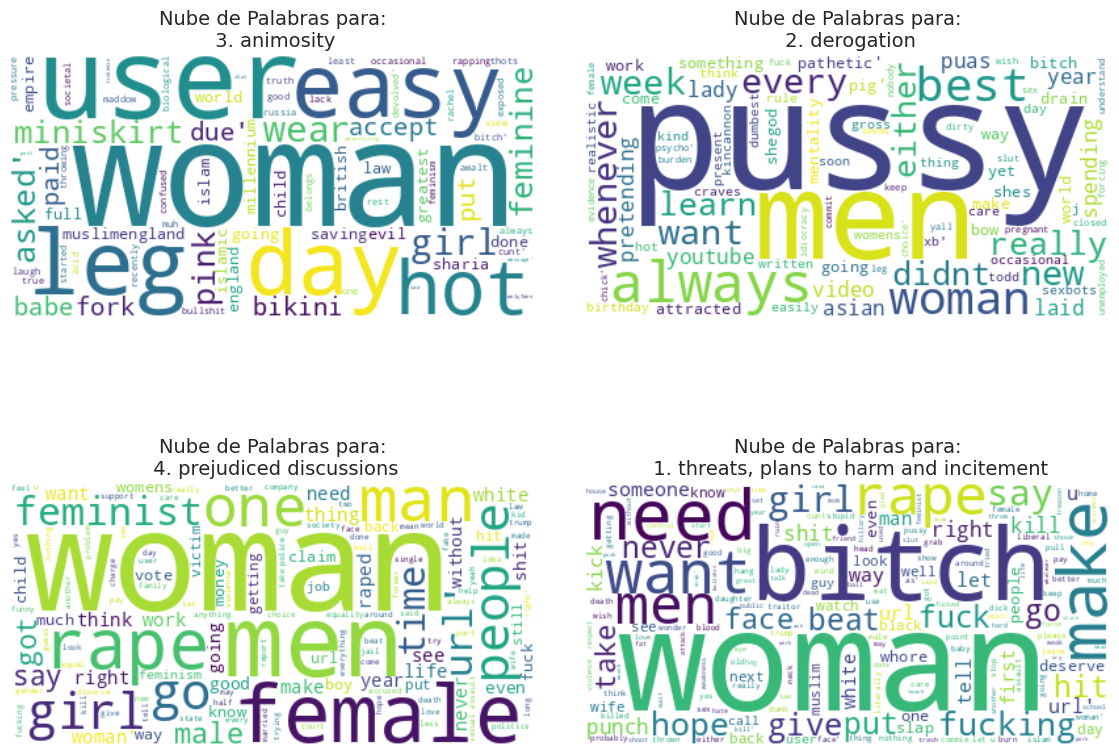

In [ ]:
# Generar nubes de palabras para cada categoría
categories = datos['label_category'].unique()

# Crear una figura con subgráficas (2x2)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Aplanar la matriz de ejes para facilitar el acceso

for i, category in enumerate(categories):
    # Filtrar comentarios por categoría
    text = datos[datos['label_category'] == category]['cleaned_text'].values

    # Crear una nube de palabras
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(str(text))

    # Mostrar la nube de palabras en el subplot correspondiente
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')  # Ocultar ejes
    axes[i].set_title(f'Nube de Palabras para:\n {category}', fontsize=14)

# Ajustar el espacio entre subgráficas
plt.tight_layout(pad=3.0)
plt.show()

## 🔹 **Vectorización de los datos**


Convierte los comentarios de texto en una representación numérica que puede ser utilizada por algoritmos de aprendizaje automático.

Decidimos usar este método:
* **TF-IDF** (Frecuencia de Término - Frecuencia Inversa de Documento): por que no solo cuenta las ocurrencias de palabras como **BoW**, sino que también considera su importancia en el conjunto de datos; reduce el peso de las palabras comunes y aumenta el peso de las palabras raras; es decir, resalta términos que son únicos y distintivos en cada categoría, lo cual es útil en nuestro caso para identificar palabras "diferenciadoras".




### TF-IDF:

In [ ]:
# Crear una instancia de TfidfVectorizer
vectorizador = TfidfVectorizer()

# Ajustar (fit) y transformar los datos
X_tfidf = vectorizador.fit_transform(datos['cleaned_text'])
y = datos['label_category']

# Convertir a un DataFrame para visualizar
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns = vectorizador.get_feature_names_out())

# Agregar la columna de categorías
df_tfidf['label_category'] = datos['label_category']

#MATRIZ DE CONTINGENCIA
# Crear la tabla de contingencia
contingency_table = df_tfidf.groupby('label_category').sum()

# Resetear el índice para que sea más fácil de leer
contingency_table.reset_index(inplace=True)

# Mostrar la tabla de contingencia
print(contingency_table)

#________________________________________________________________
# Transformar el conjunto de prueba con el vectorizador ajustado en entrenamiento
X_test_tfidf = vectorizador.transform(test['cleaned_text']) # Solo transformar el conjunto de prueba

                             label_category   aa  aaaaand  aaaannnddd  \
0  1. threats, plans to harm and incitement  0.0      0.0    0.295358   
1                             2. derogation  0.0      0.0    0.000000   
2                              3. animosity  0.0      0.0    0.000000   
3                 4. prejudiced discussions  0.0      0.0    0.000000   

         ab  abandon  abandonment  abbreviation  abc  abd  ...   zionism  \
0  0.000000      0.0     0.000000           0.0  0.0  0.0  ...  0.269797   
1  0.000000      0.0     0.279495           0.0  0.0  0.0  ...  0.000000   
2  0.386695      0.0     0.000000           0.0  0.0  0.0  ...  0.000000   
3  0.000000      0.0     0.000000           0.0  0.0  0.0  ...  0.000000   

    zionist  ziowhore      zoey  zog  zombie  zone  zoo  zoom  zulu  
0  0.000000  0.000000  0.249257  0.0     0.0   0.0  0.0   0.0   0.0  
1  0.272622  0.000000  0.000000  0.0     0.0   0.0  0.0   0.0   0.0  
2  0.000000  0.000000  0.000000  0.0     0.

## 🔹 **Selección de características**

### Filtro basado en el estadístico Chi_square:

Usando la impementación de TF-IDF anterior

In [ ]:
 # Calcular la puntuación Chi-Cuadrado y los p-valores para todas las características
chi2_scores, p_values = chi2(X_tfidf, y)
umbral_significancia = 0.1 #[0.1, 0.05, 0.01, 0.005, 0.001]

# Seleccionar los índices de las características relevantes
selected_indices_chi2 = [i for i, p in enumerate(p_values) if p < umbral_significancia]

# Crear una nueva matriz con solo las características seleccionadas
X_chi2 = X_tfidf[:, selected_indices_chi2]

# Obtener los nombres de las características seleccionadas
feature_names_chi2 = vectorizador.get_feature_names_out()
selected_words_chi2 = [feature_names_chi2[i] for i in selected_indices_chi2]

# Imprimir cuántas palabras han sido seleccionadas y mostrar las primeras 10
print(f"Numero de palabras seleccionadas por Chi-Cuadrado: {len(selected_indices_chi2)}")
print("Primeras 10 palabras seleccionadas:")
print(selected_words_chi2[:10])

#______________________________________________________________________
X_test_chi2 = X_test_tfidf[:, selected_indices_chi2] #selecciona las mismas características de train

Numero de palabras seleccionadas por Chi-Cuadrado: 104
Primeras 10 palabras seleccionadas:
['accident', 'accused', 'accuser', 'acid', 'affirmative', 'as', 'assault', 'assaulted', 'beat', 'bitch']


solo chi2, o ambos y elegir el conjunto de datos comunes entre los dos.

### Top 5 de palabras importantes por categoría:

<ipython-input-106-cbdb72ee9423>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grupo: grupo.nlargest(ntop, 'Puntaje_Chi2')).reset_index(drop=True)


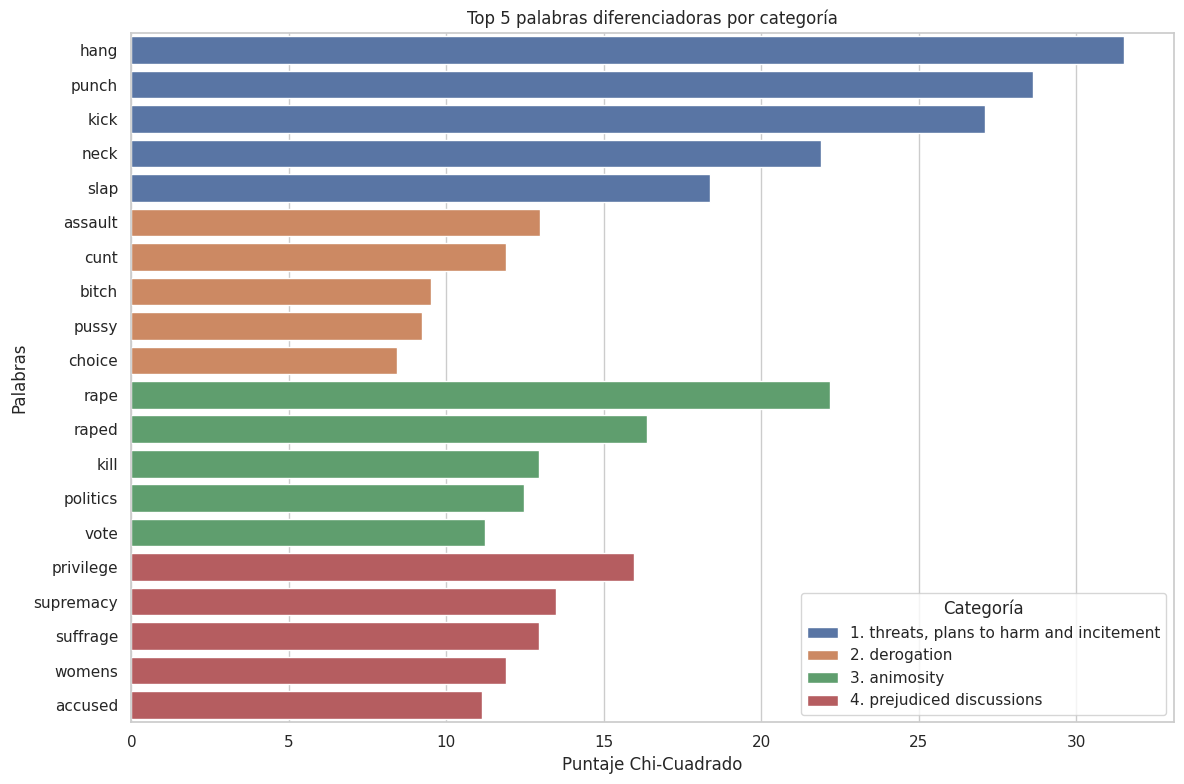

In [ ]:
# Crear un DataFrame con las palabras seleccionadas, sus puntajes chi2 y la categoría asociada
import pandas as pd
top_words = pd.DataFrame({
    'Palabra': [feature_names_chi2[i] for i in selected_indices_chi2],
    'Puntaje_Chi2': [chi2_scores[i] for i in selected_indices_chi2],
    'Categoría': [ y.reset_index(drop=True)[np.argmax(X_tfidf[:, i].toarray())]
                for i in selected_indices_chi2]})

# Obtener el top 15 palabras por categoría
ntop = 5
topN_por_categoria = ( top_words.groupby('Categoría')
    .apply(lambda grupo: grupo.nlargest(ntop, 'Puntaje_Chi2')).reset_index(drop=True)
)

# Graficar
plt.figure(figsize=(12, 8))
sns.barplot( data=topN_por_categoria, x='Puntaje_Chi2', y='Palabra', hue='Categoría', dodge=False)
plt.title('Top 5 palabras diferenciadoras por categoría')
plt.xlabel('Puntaje Chi-Cuadrado')
plt.ylabel('Palabras')
plt.legend(title='Categoría')
plt.tight_layout()
plt.show()

# 🟠 **Seleccionar el modelo, ajustarlo y evaluarlo**

Se hace la implementación de todos estos modelos:

1. Regresión multivariada: Regresión logística multinomial
2. Árboles de decisión
3. Random Forest
4. Redes neuronales

Comparando sus resultados (**Accuracy y Matriz de confusión**), que surgen de utilizar la función **GridSearchCV** la cual además de automatizar las pruebas de múltiples combinaciones de parámetros, también implementa una estrategia de repetición de cada experimento llamada validación cruzada.




Las variables a usar en los modelos de **Árboles de Decisión** y **Random Forest** son:

* Para el entrenamiento: [ *X_chi2* , y ]
* Para la prueba: con *X_test_chi2*

En los modelos de **Regresión Logística Multinomial** y **Redes Neuronales**, debido a que estan basadas en ***Descenso por la pendiente***, primero se deben escalar (llevar a ceros y unos) las variables a usar, así que estas serían:

* Para el entrenamiento: [ *X_scaled* , y ]
* Para la prueba: Con *X_test_scaled*

In [ ]:
# Escalar las características finales seleccionadas por chi2
scaler = StandardScaler(with_mean=False)  # Es False porque X es una matriz dispersa
X_scaled = scaler.fit_transform(X_chi2)
X_test_scaled = scaler.transform(X_test_chi2)

## 🔸 **Regresión logística multinomial:**

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Mejores parámetros encontrados por GridSearchCV:
{'C': 10, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg'}

Reporte de clasificación en el conjunto de prueba:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       0.52      0.29      0.37        89
                           2. derogation       0.50      0.77      0.61       454
                            3. animosity       0.48      0.26      0.34       333
               4. prejudiced discussions       0.40      0.19      0.26        94

                                accuracy                           0.50       970
                               macro avg       0.48      0.38      0.40       970
                            weighted avg       0.49      0.50      0.46       970

Precisión: 0.49587628865979383


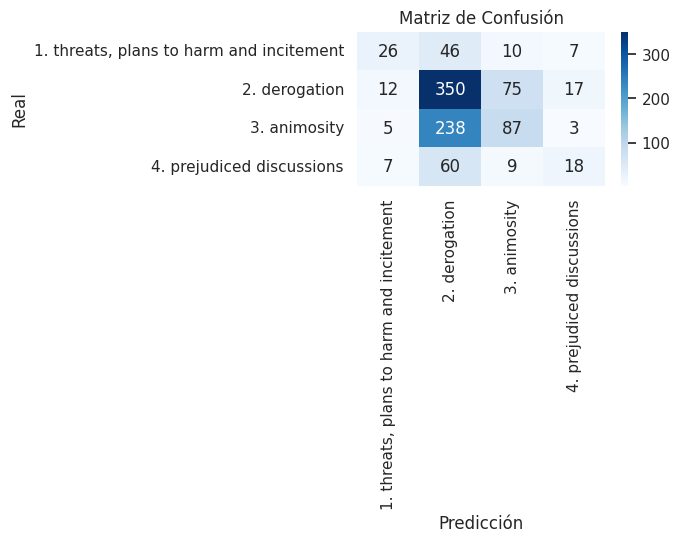

In [ ]:
# Crear una instancia del modelo de regresión logística multiclase
log_reg = LogisticRegression(max_iter=1000)

# Definir los parámetros para GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Parámetro de regularización
    'solver': ['lbfgs', 'newton-cg'],  # Solvers para la regresión logística
    'penalty': ['l2'],  # Tipo de penalización comun en multinomial
    'multi_class': ['multinomial']  # Configuración para clasificación multinomial
}

# Configurar GridSearchCV con validación cruzada (5 pliegues)
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Ajustar el modelo con el conjunto de entrenamiento escalado
grid_search.fit(X_scaled, y)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros encontrados por GridSearchCV:")
print(grid_search.best_params_)

# Hacer predicciones en el conjunto de prueba escalado
y_pred = grid_search.predict(X_test_scaled)

# Evaluar el rendimiento del modelo en el conjunto de prueba
print("\nReporte de clasificación en el conjunto de prueba:")
print(classification_report(test['label_category'], y_pred))
print(f"Precisión: {accuracy_score(test['label_category'], y_pred)}")

conf_matrix = confusion_matrix(test['label_category'], y_pred)

# Mostrar la matriz de confusión
plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(test['label_category']),
            yticklabels=np.unique(test['label_category']))
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

Se observa que el parámetro que ofrece un mejor resultado es C= 10, sin embargo el accuracy es del 49% y la matriz de confusión muestra muchos errores en la clasificación de las variables.
En la categoría 2, el recall de (77%) y F1-score de (61%) sugiere que el modelo está sesgado hacia esta clase, porque tiene más muestras en los datos que las otras, por lo que el modelo ignora en gran parte las otras categorías, especialmente las menos representadas (1 y 4).


Entonces, se confirma que el desbalanceamiento de las clases esta afectando en los resultados, y se deben tomar medidas al respecto:

### **Balanceando los datos:**

Debido a que las clases están divididas así:
1. threats, plans to harm and incitement = 9.1%
2. derogation = 46.8%
3. animosity = 34.3%
4. prejudiced discussions = 9.8%

In [ ]:
print(conteo_tipos)

label_category
2. derogation                               1590
3. animosity                                1165
4. prejudiced discussions                    333
1. threats, plans to harm and incitement     310
Name: count, dtype: int64


Y hay mucha diferencia entre las categorías 1 y 4, y las 2 y 3, el mejor plan sería realizar una combinacion de submuestreo **(Undersampling)** y sobremuestreo **(Oversampling)**:
* **Oversampling:** de las clases 1 y 4 con **SMOTE** para que tengan una mayor representación en el conjunto de entrenamiento.

* **Undersampling:** moderado en las clases 2 y 3, para reducir su impacto sin perder demasiados datos con **RandomUnderSampler**.



Distribución de clases antes del balanceo (en porcentajes):
 {'3. animosity': '34.28%', '2. derogation': '46.79%', '4. prejudiced discussions': '9.80%', '1. threats, plans to harm and incitement': '9.12%'}

Distribución de clases después del balanceo (en porcentajes):
 {'1. threats, plans to harm and incitement': '25.00%', '2. derogation': '25.00%', '3. animosity': '25.00%', '4. prejudiced discussions': '25.00%'}
Dimensiones de X_scaledB: (1600, 104)
Dimensiones de X_test_scaled: (970, 104)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Mejores parámetros encontrados por GridSearchCV:
{'C': 0.01, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg'}

Reporte de clasificación:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       0.39      0.46      0.42        89
                           2. derogation       0.53      0.62      0.57       454
                            3. animosity       0.49      0.34      0.40       333
               4. prejudiced discussions       0.34      0.38      0.36        94

                                accuracy                           0.49       970
                               macro avg       0.44      0.45      0.44       970
                            weighted avg       0.49      0.49      0.48       970

Precisión: 0.4865979381443299


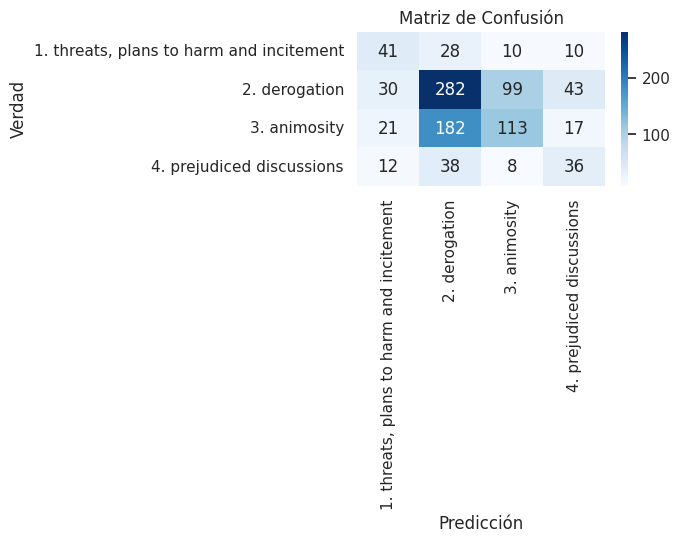

In [ ]:
# Configuración del balanceo específico para cada clase
target_counts = {
    "1. threats, plans to harm and incitement": 400,  # Aumentar con SMOTE
    "2. derogation": 400,  # Reducir con submuestreo
    "3. animosity": 400,  # Reducir con submuestreo
    "4. prejudiced discussions": 400  # Aumentar con SMOTE
}

# Sobremuestreo con SMOTE solo para las clases 1 y 4
smote = SMOTE(sampling_strategy={
    "1. threats, plans to harm and incitement": target_counts["1. threats, plans to harm and incitement"],
    "4. prejudiced discussions": target_counts["4. prejudiced discussions"]
}, random_state=42)

X_smote, y_smote = smote.fit_resample(X_chi2, y)

# Submuestreo con RandomUnderSampler solo para las clases 2 y 3
under_sampler = RandomUnderSampler(sampling_strategy={
    "2. derogation": target_counts["2. derogation"],
    "3. animosity": target_counts["3. animosity"]
}, random_state=42)

X_balanced, y_balanced = under_sampler.fit_resample(X_smote, y_smote)
#X_balanced, y_balanced = under_sampler.fit_resample(X_chi2, y)
#X_balanced, y_balanced = smote.fit_resample(X_chi2, y)

# Función para calcular y mostrar la distribución de clases en porcentajes
def mostrar_distribucion(clases):
    total = sum(clases.values())
    return {k: f"{(v / total) * 100:.2f}%" for k, v in clases.items()}

# Imprimir distribución de clases después del balanceo
print("\nDistribución de clases antes del balanceo (en porcentajes):\n", mostrar_distribucion(Counter(y)))
print("\nDistribución de clases después del balanceo (en porcentajes):\n", mostrar_distribucion(Counter(y_balanced)))
#______________________________________________________________________________________
# # Entrenar de nuevo el modelo con los datos balanceados
X_test_chi2 = X_test_tfidf[:, selected_indices_chi2]

X_scaledB = scaler.fit_transform(X_balanced)
X_test_scaledB = scaler.transform(X_test_chi2)

# Validar dimensiones
print(f"Dimensiones de X_scaledB: {X_scaledB.shape}")
print(f"Dimensiones de X_test_scaled: {X_test_scaledB.shape}")

# Crear una instancia del modelo de regresión logística multiclase
log_reg = LogisticRegression(max_iter=1000)

# Definir los parámetros para GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Parámetro de regularización
    'solver': ['lbfgs', 'newton-cg'],  # Solvers para la regresión logística
    'penalty': ['l2'],  # Tipo de penalización comun en multinomial
    'multi_class': ['multinomial']  # Configuración para clasificación multinomial
}

# Configurar GridSearchCV con validación cruzada (5 pliegues)
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Ajustar el modelo con el conjunto de entrenamiento escalado
grid_search.fit(X_scaledB, y_balanced)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros encontrados por GridSearchCV:")
print(grid_search.best_params_)

# Hacer predicciones en el conjunto de prueba escalado
y_pred = grid_search.predict(X_test_scaledB)

# Evaluar el modelo
print("\nReporte de clasificación:")
print(classification_report(test['label_category'], y_pred))
print(f"Precisión: {accuracy_score(test['label_category'], y_pred)}")

# Matriz de confusión
conf_matrix = confusion_matrix(test['label_category'], y_pred)
plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(test['label_category']),
            yticklabels=np.unique(test['label_category']))
plt.xlabel("Predicción")
plt.ylabel("Verdad")
plt.title("Matriz de Confusión")
plt.show()

Pese a que se intentaron varias formas de balanceo de datos y tambien como influia el umbral de chi2 en el resultado, la mejor opción que encontramos fue esta, con un accuracy del 48%, utilizando los parametros: C = 0.01, y solver = newton-cg.

Con el balanceo se reduce el sesgo hacia la clase 2 (antes mayoritaria) y se mejora la capacidad del modelo para detectar categorías subrepresentadas.
Sin embargo, el modelo sigue teniendo dificultades para diferenciar entre las clases 3 y 4, lo que podría deberse a similitudes en el contenido textual.


En conclusión, hasta ahora el mejor resultado sería **usar el modelo despues de balancear** los datos, porque aunque la precisión global sea menor a la primera implementacion (sin balanceo), en realidad es muy similar; además, después del balanceo el modelo muestra un mejor equilibrio en las predicciones para todas las clases.

## 🔸 **Árboles de decisión:**



Accuracy de DecisionTreeClassifier sobre el conjunto de prueba es: 0.47


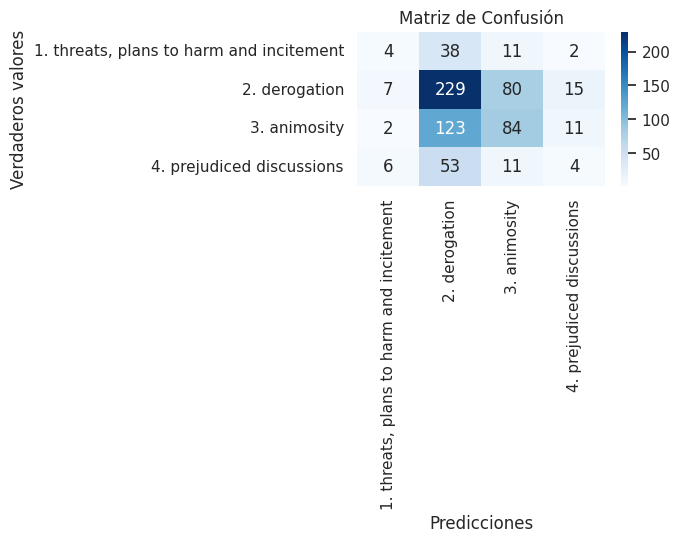

              precision    recall  f1-score   support

           0       0.21      0.07      0.11        55
           1       0.52      0.69      0.59       331
           2       0.45      0.38      0.41       220
           3       0.12      0.05      0.08        74

    accuracy                           0.47       680
   macro avg       0.33      0.30      0.30       680
weighted avg       0.43      0.47      0.44       680



In [ ]:
# Aplicando árboles de decisión con búsqueda de hiperparámetros
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Dividir el conjunto de datos en entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(X_chi2, y, test_size=0.20, random_state=42)

# Crear el modelo base
clf = DecisionTreeClassifier(random_state=42)

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Configurar la búsqueda con GridSearchCV
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Ajustar el modelo a los datos de entrenamiento
grid_search.fit(x_train, y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros encontrados por GridSearchCV:")
print(grid_search.best_params_)

# Evaluar el mejor modelo en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

# Calcular métricas de evaluación
accuracy = best_model.score(x_test, y_test)
print(f'\nAccuracy del mejor modelo en el conjunto de prueba: {accuracy:.2f}')

# Matriz de confusión
cmatrix = confusion_matrix(y_test, y_pred)
print("\nMatriz de confusión:")
print(cmatrix)

# Reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))


El análisis del modelo de árbol de decisión optimizado mediante búsqueda de hiperparámetros muestra resultados con un rendimiento limitado. Si bien la búsqueda exhaustiva identificó un conjunto de parámetros que maximiza el ajuste, la precisión global en el conjunto de prueba es moderada, indicando que el modelo tiene dificultades para generalizar de manera efectiva.

La matriz de confusión refleja un desempeño desigual entre las diferentes clases. Algunas categorías muestran un desequilibrio significativo en la capacidad del modelo para identificarlas correctamente, lo que se traduce en un bajo recall para ciertas clases. Este patrón sugiere que el modelo podría estar sesgado hacia las clases con mayor representación en los datos, comprometiendo su capacidad de capturar patrones en categorías menos frecuentes.

El reporte de clasificación refuerza esta observación, ya que los valores de precision, recall y f1-score varían notablemente entre las clases. Esto indica que, aunque el modelo puede ser razonablemente efectivo en identificar correctamente algunas categorías, su rendimiento general se ve afectado por las dificultades para manejar la complejidad y diversidad del conjunto de datos. El bajo promedio macro y ponderado de las métricas evidencia que el modelo no logra un rendimiento equilibrado en todo el conjunto de clases, lo que limita su aplicabilidad en escenarios donde la equidad entre categorías sea crucial.

//añadir las fuentes

## 🔸 **Random Forest:**





Mejores parámetros encontrados: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 200}

Reporte de Clasificación:
                                          precision    recall  f1-score   support

                            3. animosity       0.51      0.21      0.30        89
                           2. derogation       0.50      0.77      0.61       454
               4. prejudiced discussions       0.45      0.29      0.35       333
1. threats, plans to harm and incitement       0.35      0.10      0.15        94

                                accuracy                           0.49       970
                               macro avg       0.45      0.34      0.35       970
                            weighted avg       0.47      0.49      0.45       970


Precisión en el conjunto de prueba: 0.4896907216494845

Matriz de Confusión:


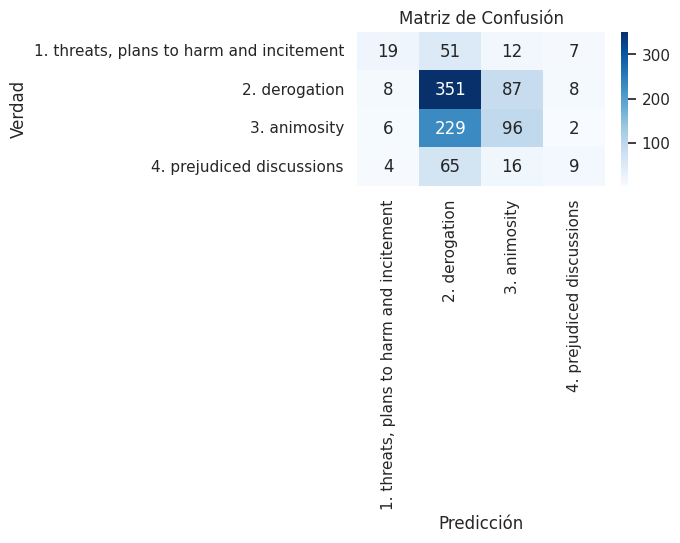

In [ ]:
# Configurar los hiperparámetros para GridSearchCV
param_grid = {
    'n_estimators': [100, 200],  # Número de árboles en el bosque
    'max_depth': [10, 20, 30],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],  # Mínimo número de muestras para dividir un nodo
    'criterion': ['gini', 'entropy']  # Función para medir la calidad de una división
}

# Crear el modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='f1_weighted',  # Métrica de evaluación: F1 ponderado
    cv=5,                   # Número de particiones para validación cruzada
)

# Entrenar el modelo utilizando GridSearchCV
grid_search.fit(X_chi2, y)

# Imprimir los mejores parámetros encontrados por GridSearchCV
print(f"Mejores parámetros encontrados: {grid_search.best_params_}")

# Obtener el mejor modelo
best_rf_model = grid_search.best_estimator_

# Evaluar el modelo en el conjunto de prueba
y_pred = best_rf_model.predict(X_test_chi2)

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(test['label_category'], y_pred, target_names=y.unique()))

# Precisión general
accuracy = accuracy_score(test['label_category'], y_pred)
print(f"\nPrecisión en el conjunto de prueba: {accuracy}")

# Matriz de confusión
print("\nMatriz de Confusión:")
conf_matrix3 = confusion_matrix(test['label_category'], y_pred)
plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix3, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(test['label_category']),
            yticklabels=np.unique(test['label_category']))
plt.xlabel("Predicción")
plt.ylabel("Verdad")
plt.title("Matriz de Confusión")
plt.show()

//analisis

### Con datos balanceados:

In [ ]:
# Entrenar el modelo utilizando GridSearchCV
grid_search.fit(X_balanced, y_balanced)

# Imprimir los mejores parámetros encontrados por GridSearchCV
print(f"Mejores parámetros encontrados: {grid_search.best_params_}")

# Obtener el mejor modelo
best_rf_model = grid_search.best_estimator_

# Evaluar el modelo en el conjunto de prueba
y_pred = best_rf_model.predict(X_test_chi2)

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(test['label_category'], y_pred, target_names=y.unique()))

# Precisión general
accuracy = accuracy_score(test['label_category'], y_pred)
print(f"\nPrecisión en el conjunto de prueba: {accuracy}")

# Matriz de confusión
print("\nMatriz de Confusión:")
conf_matrix3 = confusion_matrix(test['label_category'], y_pred)
plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix3, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(test['label_category']),
            yticklabels=np.unique(test['label_category']))
plt.xlabel("Predicción")
plt.ylabel("Verdad")
plt.title("Matriz de Confusión")
plt.show()


//analisis de este resultado

//analisis de cual de los dos elijes y why

## 🔸 **Redes neuronales:**



In [ ]:
#desarrollar aquí con esos parámetros
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix



clf = MLPClassifier()
clf.fit(X_scaled, y)
y_pred = clf.predict(X_test_scaled)
y_prob = clf.predict_proba(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm)

mlp_precision = 100 * accuracy_score(y_test, y_pred)
print('Precisión: {0:.3f}%'.format(mlp_precision))

plt.figure(figsize=(4, 2))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title('MLP (initial)')
plt.ylabel('Valor real')
plt.xlabel('Valor estimado')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


ValueError: Found input variables with inconsistent numbers of samples: [680, 970]

**Requisito:** Una explicación o análisis del resultado final obtenido por los modelos con los parámetros ajustados debe incluir métricas de evaluación como accuracy, y matrices de
confusión. Este análisis también debe aparecer descrito y documentado en el notebook de trabajo.

//añadir las fuentes

# 🔴 **Resultado final**

//Modelo seleccionado, hacer analisis de datos y dar resultado

**Requisito:** Conclusiones de los resultados obtenidos de acuerdo con el objetivo del conjunto de datos asignado, incluyendo trabajo futuro que se pueda realizar para mejorar los
resultados, o la evaluación del modelo. Estas deben estar de manera explícita en el notebook de trabajo.

# 🟤 **Referencias bibliográficas:**



Repositorio: https://github.com/idanis/IA_Unimagdalena.git

Notebooks:
1.   seleccion_caracteristica/ejemplo_feature_selection_ver2.ipynb
2.   regression/regresion_clasificacion_wine.ipynb
3.   otros ejemplos/ejemplo_depresion.ipynb
4.   otros ejemplos/Trabajo_ej_IA2023I.ipynb

Diapositivas proporcionadas por la docente mediante el campus virtual

